<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="Rossum"></p>

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import warnings
warnings.filterwarnings('ignore')

In [2]:
pwd

'C:\\Users\\msmsk\\cats'

The Dogs vs. Cats dataset is a common computer vision dataset in which pictures are classified as either including a dog or a cat.

After the dataset is well studied, it can be used to understand and practice how to design, evaluate, and apply convolutional neural networks for image classification.

You will build a classifier with images and try to detect dogs versus cats using CNN.

Train set includes 12500 cat-5026 dog images, validation set includes 1219 cat-1071 dog images and test set incgludes 6897 cat and dogs images together. 

In [9]:
my_data_dir='C:\\Users\\msmsk\\cats'

In [4]:
os.listdir(my_data_dir)

['.ipynb_checkpoints',
 'CNN_project_catdogclassifier_solution.ipynb',
 'test',
 'test-20211103T203550Z-001.zip',
 'train',
 'train-20211103T203556Z-001.zip',
 'validation',
 'validation-20211103T203558Z-001.zip']

In [20]:
val_path = my_data_dir+'\\validation\\'
train_path = my_data_dir+'\\train\\'
test_path = my_data_dir+'\\test\\'

In [6]:
os.listdir(train_path)

['cat', 'dog']

In [7]:
len(os.listdir(test_path))

6897

**Let's check how many images there are.**

In [8]:
len(os.listdir(train_path+'\\cat'))

12500

In [9]:
len(os.listdir(train_path+'\\dog'))

5026

In [10]:
os.listdir(train_path+'cat')[0]

'cat.0.jpg'

In [11]:
path1=train_path+'/cat'+'/cat.0.jpg'
path2=train_path+'/dog'+'/dog.1.jpg'

In [12]:
cat_img=imread(path1)
dog_img=imread(path2)

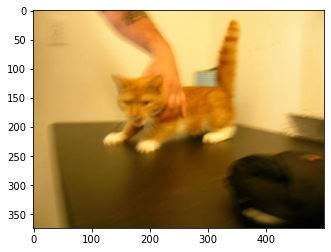

In [13]:
plt.imshow(cat_img)

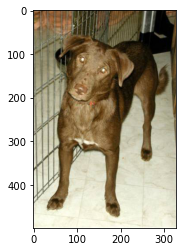

In [14]:
plt.imshow(dog_img)

**Let's decide on the final dimension of these images.**

In [15]:
cat_img.shape

(374, 500, 3)

In [16]:
dog_img.shape

(499, 327, 3)

In [17]:
x= []
y = []
for image in os.listdir(train_path+'\\cat'):
    
    img = imread(train_path+'\\cat'+'\\'+image)
    d1,d2,colors = img.shape
    x.append(d1)
    y.append(d2)

<AxesSubplot:>

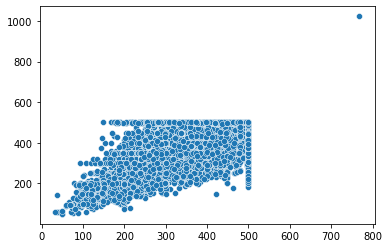

In [18]:
sns.scatterplot(x,y)

In [19]:
np.mean(x)

356.46712

In [20]:
np.mean(y)

410.52264

In [21]:
image_shape = (128,128,3)

In [22]:
# help(ImageDataGenerator)

**Image Manipulation**

We can use the ImageDataGenerator to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. ImageDataGenerator does the followings.

* Accepts a batch of images used for training.
* Applies a series of random transformations to each image in the batch.
* Replaces the original batch with randomly transformed batch.
* Training the CNN on this randomly transformed batch.

The goal of applying data augmentation is to have a more generalized model.

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

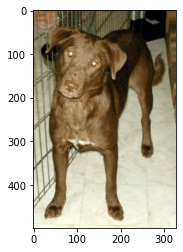

In [25]:
plt.imshow(image_gen.random_transform(dog_img))

### Generating many manipulated images from a directory


flow_from_directory function works with images organized in sub-directories. Your directories should include only one class of images, so one folder per class of images.

<img src="flw.png" width=380 height=380>

image_gen.flow_from_directory(train_path)

In [26]:
image_gen.flow_from_directory(val_path)

Found 2290 images belonging to 2 classes.


In [27]:
image_gen.flow_from_directory(test_path)

Found 0 images belonging to 0 classes.


# Creating the Model

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [29]:

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))


model.add(Dropout(0.5))


model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

## Early Stopping

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [33]:
batch_size = 16

In [34]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 17526 images belonging to 2 classes.


In [35]:
val_image_gen = image_gen.flow_from_directory(val_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2290 images belonging to 2 classes.


In [36]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 0 images belonging to 0 classes.


In [37]:
train_image_gen.class_indices

{'cat': 0, 'dog': 1}

In [38]:
test_image_gen.class_indices

{}

## Model Training

In [39]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
results = model.fit_generator(train_image_gen,epochs=10,
                              validation_data=val_image_gen,
                             callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
1096/1096 [==============================] - 522s 476ms/step - loss: 0.5866 - accuracy: 0.7135 - val_loss: 0.7140 - val_accuracy: 0.5384
Epoch 2/10
1096/1096 [==============================] - 476s 435ms/step - loss: 0.5251 - accuracy: 0.7494 - val_loss: 0.6954 - val_accuracy: 0.6218
Epoch 3/10
1096/1096 [==============================] - 470s 429ms/step - loss: 0.4743 - accuracy: 0.7771 - val_loss: 0.5324 - val_accuracy: 0.7445
Epoch 4/10
1096/1096 [==============================] - 472s 431ms/step - loss: 0.4468 - accuracy: 0.7954 - val_loss: 0.5580 - val_accuracy: 0.7245
Epoch 5/10
1096/1096 [==============================] - 474s 432ms/step - loss: 0.4264 - accuracy: 0.8102 - val_loss: 0.5871 - val_accuracy: 0.7279


# Evaluating the Model

In [41]:
summary = pd.DataFrame(model.history.history)
summary.head()

,loss,accuracy,val_loss,val_accuracy
0,0.586589,0.713454,0.713977,0.538428
1,0.525079,0.749401,0.695421,0.621834
2,0.474290,0.777074,0.532397,0.744541
3,0.446777,0.795390,0.558006,0.724454
4,0.426371,0.810168,0.587119,0.727948


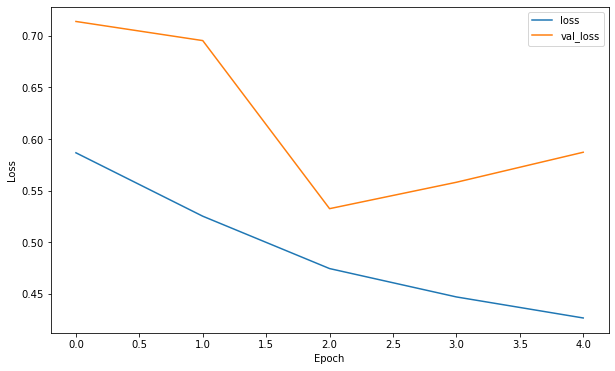

In [42]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

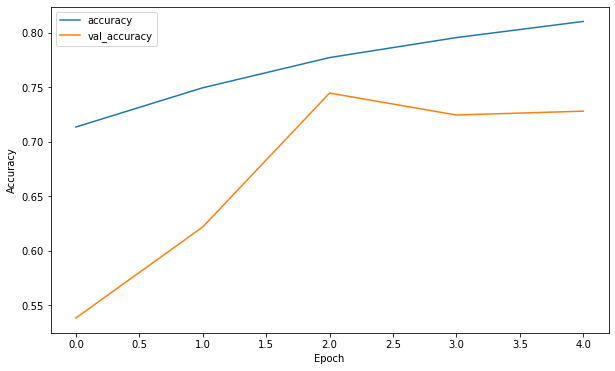

In [43]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [44]:
model.metrics_names

['loss', 'accuracy']

In [45]:
model.evaluate_generator(val_image_gen)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.5850883722305298, 0.7388646006584167]

In [47]:
pred_probabilities = model.predict_generator(val_image_gen)

Instructions for updating:
Please use Model.predict, which supports generators.


In [48]:
pred_probabilities

array([[0.02024201],
       [0.07333052],
       [0.47181943],
       ...,
       [0.9688102 ],
       [0.9578027 ],
       [0.957479  ]], dtype=float32)

In [49]:
val_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [50]:
predictions = pred_probabilities > 0.5

In [51]:
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [52]:
from sklearn.metrics import classification_report,confusion_matrix

In [53]:
print(classification_report(val_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.69      0.95      0.80      1219
           1       0.89      0.51      0.65      1071

    accuracy                           0.74      2290
   macro avg       0.79      0.73      0.72      2290
weighted avg       0.78      0.74      0.72      2290



In [54]:
confusion_matrix(val_image_gen.classes,predictions)

array([[1154,   65],
       [ 530,  541]], dtype=int64)

In [3]:
from tensorflow.keras.models import load_model
#model.save('cat_dog_detector.h5')

# Predicting on an Image

In [4]:
from tensorflow.keras.preprocessing import image

In [7]:
model=load_model('cat_dog_detector.h5')

In [56]:
#from PIL import Image

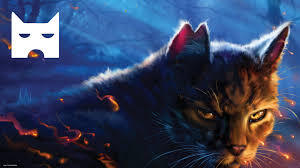

In [12]:
img=image.load_img(my_data_dir+'/test'+'/madcat2.jpeg')
img

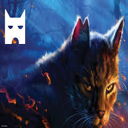

In [13]:
resized_img = img.resize((128, 128))
resized_img

In [14]:
resized_img1=np.array(resized_img)
resized_img1.shape

(128, 128, 3)

In [15]:
resized_img1=np.expand_dims(resized_img1, axis=0)
resized_img1.shape

(1, 128, 128, 3)

In [18]:
model.predict(resized_img1).round()

array([[0.]], dtype=float32)